#### Data fields description:

ID - an Id that represents a (Shop, Item) tuple within the test set

shop_id - unique identifier of a shop

item_id - unique identifier of a product

item_category_id - unique identifier of item category

date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

date - date in format dd/mm/yyyy

item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

item_price - current price of an item

item_name - name of item

shop_name - name of shop

item_category_name - name of item category

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import catboost
# from catboost import Pool
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [2]:
test = pd.read_csv('../Data/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('../Data/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('../Data/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('../Data/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('../Data/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [3]:
display(sales.head())
display(test.head())
display(item_categories.head())
display(items.head())
display(shops.head())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1
1,03.01.2013,0,25,2552,899.00,1
2,05.01.2013,0,25,2552,899.00,-1
3,06.01.2013,0,25,2554,1709.05,1
4,15.01.2013,0,25,2555,1099.00,1


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


Join data sets

In [4]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
print(train.shape)
train.head()

(2935849, 10)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,02.01.2013,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [10]:
# Create a column "item_price_sum"
train['item_price_sum'] = train['item_price'] * train['item_cnt_day']
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,item_price_sum
0,02.01.2013,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,999.00
1,03.01.2013,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,899.00
2,05.01.2013,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,-899.00
3,06.01.2013,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,1709.05
4,15.01.2013,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,1099.00


In [12]:
train.head().T

,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [13]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_price_sum
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00,1157.73
std,9.42,16.23,6324.30,1729.80,2.62,17.10,5683.60
min,0.00,0.00,0.00,-1.00,-22.00,0.00,-68970.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00,249.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00,449.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00,1078.20
max,33.00,59.00,22169.00,307980.00,2169.00,83.00,1829990.00


Time period of the dataset

In [14]:
print('Min date from train set: %s' % pd.to_datetime(train['date'], format='%d.%m.%Y').min().date())
print('Max date from train set: %s' % pd.to_datetime(train['date'], format='%d.%m.%Y').max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-10-31


I'll only be using only the "shop_id" and "item_id" that appear on the test set.

In [15]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

# Only shops that exist in test set.
train_new = train[train['shop_id'].isin(test_shop_ids)]

# Only items that exist in test set.
train_new = train_new[train_new['item_id'].isin(test_item_ids)]

In [16]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', train_new.shape[0])

Data set size before leaking: 2935849
Data set size after leaking: 1224439


Only records with "item_price_sum" > 0.

In [17]:
train_new = train_new[train_new['item_price_sum'] > 0]
print('Data set size after cleaning:', train_new.shape[0])

Data set size after cleaning: 1221498


I'm dropping the text features since I won't be doing anything with them.
We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's remove unwanted columns and aggregate the data by month.

In [32]:
# Select only useful features.
train_monthly = train_new[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price_sum', 'item_cnt_day']]
train_monthly.head()

,date,date_block_num,shop_id,item_category_id,item_id,item_price_sum,item_cnt_day
0,02.01.2013,0,59,37,22154,999.00,1
10,03.01.2013,0,25,55,2574,798.00,2
11,05.01.2013,0,25,55,2574,399.00,1
12,07.01.2013,0,25,55,2574,399.00,1
13,08.01.2013,0,25,55,2574,798.00,2


In [33]:
# Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price_sum':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
display(train_monthly.head())
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id',  'item_id', 'sum_item_price_month', 'mean_item_price', 'sum_item_cnt_month', 'mean_item_cnt', 'transactions_month']
display(train_monthly.head())


date_block_num shop_id item_category_id item_id item_price_sum          \
                                                             sum    mean   
0              0       2                2    5572       13910.00 1987.14   
1              0       2                2    5643        2390.00 2390.00   
2              0       2                5    5583        1188.30  594.15   
3              0       2                6    7893        5970.00 1990.00   
4              0       2                6    7894        1490.00 1490.00   

  item_cnt_day             
           sum mean count  
0            9 1.29     7  
1            1 1.00     1  
2            2 1.00     2  
3            3 1.00     3  
4            1 1.00     1

,date_block_num,shop_id,item_category_id,item_id,sum_item_price_month,mean_item_price,sum_item_cnt_month,mean_item_cnt,transactions_month
0,0,2,2,5572,13910.00,1987.14,9,1.29,7
1,0,2,2,5643,2390.00,2390.00,1,1.00,1
2,0,2,5,5583,1188.30,594.15,2,1.00,2
3,0,2,6,7893,5970.00,1990.00,3,1.00,3
4,0,2,6,7894,1490.00,1490.00,1,1.00,1


To mimic the real behavior of the data we have to create the missing records from the loaded dataset, so for each month we need to create the missing records for each shop and item, since we don't have data for them I'll replace them with 0.

In [34]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [35]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)
display(train_monthly.head().T)

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
sum_item_price_month,13910.00,2390.00,1188.30,5970.00,1490.00
mean_item_price,1987.14,2390.00,594.15,1990.00,1490.00
sum_item_cnt_month,9.00,1.00,2.00,3.00,1.00
mean_item_cnt,1.29,1.00,1.00,1.00,1.00
transactions_month,7.00,1.00,2.00,3.00,1.00


In [37]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.00,16.50,9.81,0.00,8.00,16.50,25.00,33.00
shop_id,6734448.00,31.64,17.56,2.00,16.00,34.50,47.00,59.00
item_id,6734448.00,11041.89,6210.74,30.00,5385.25,11265.50,16068.25,22167.00
item_category_id,6734448.00,3.78,13.21,0.00,0.00,0.00,0.00,83.00
sum_item_price_month,6734448.00,255.69,6074.12,0.00,0.00,0.00,0.00,6264229.93
mean_item_price,6734448.00,93.79,1295.93,0.00,0.00,0.00,0.00,996950.00
sum_item_cnt_month,6734448.00,0.24,3.46,0.00,0.00,0.00,0.00,2253.00
mean_item_cnt,6734448.00,0.10,0.61,0.00,0.00,0.00,0.00,1000.00
transactions_month,6734448.00,0.18,0.90,0.00,0.00,0.00,0.00,31.00


In [38]:
# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,sum_item_price_month,mean_item_price,sum_item_cnt_month,mean_item_cnt,transactions_month,year,month
0,0,2,5572,2.00,13910.00,1987.14,9.00,1.29,7.00,2013,0
1,0,2,5643,2.00,2390.00,2390.00,1.00,1.00,1.00,2013,0
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0


# EDA

In [40]:
# Grouping data for EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['sum_item_cnt_month'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['sum_item_cnt_month'].sum()

gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['sum_item_cnt_month'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['sum_item_cnt_month'].sum()

gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['sum_item_cnt_month'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['sum_item_cnt_month'].sum()

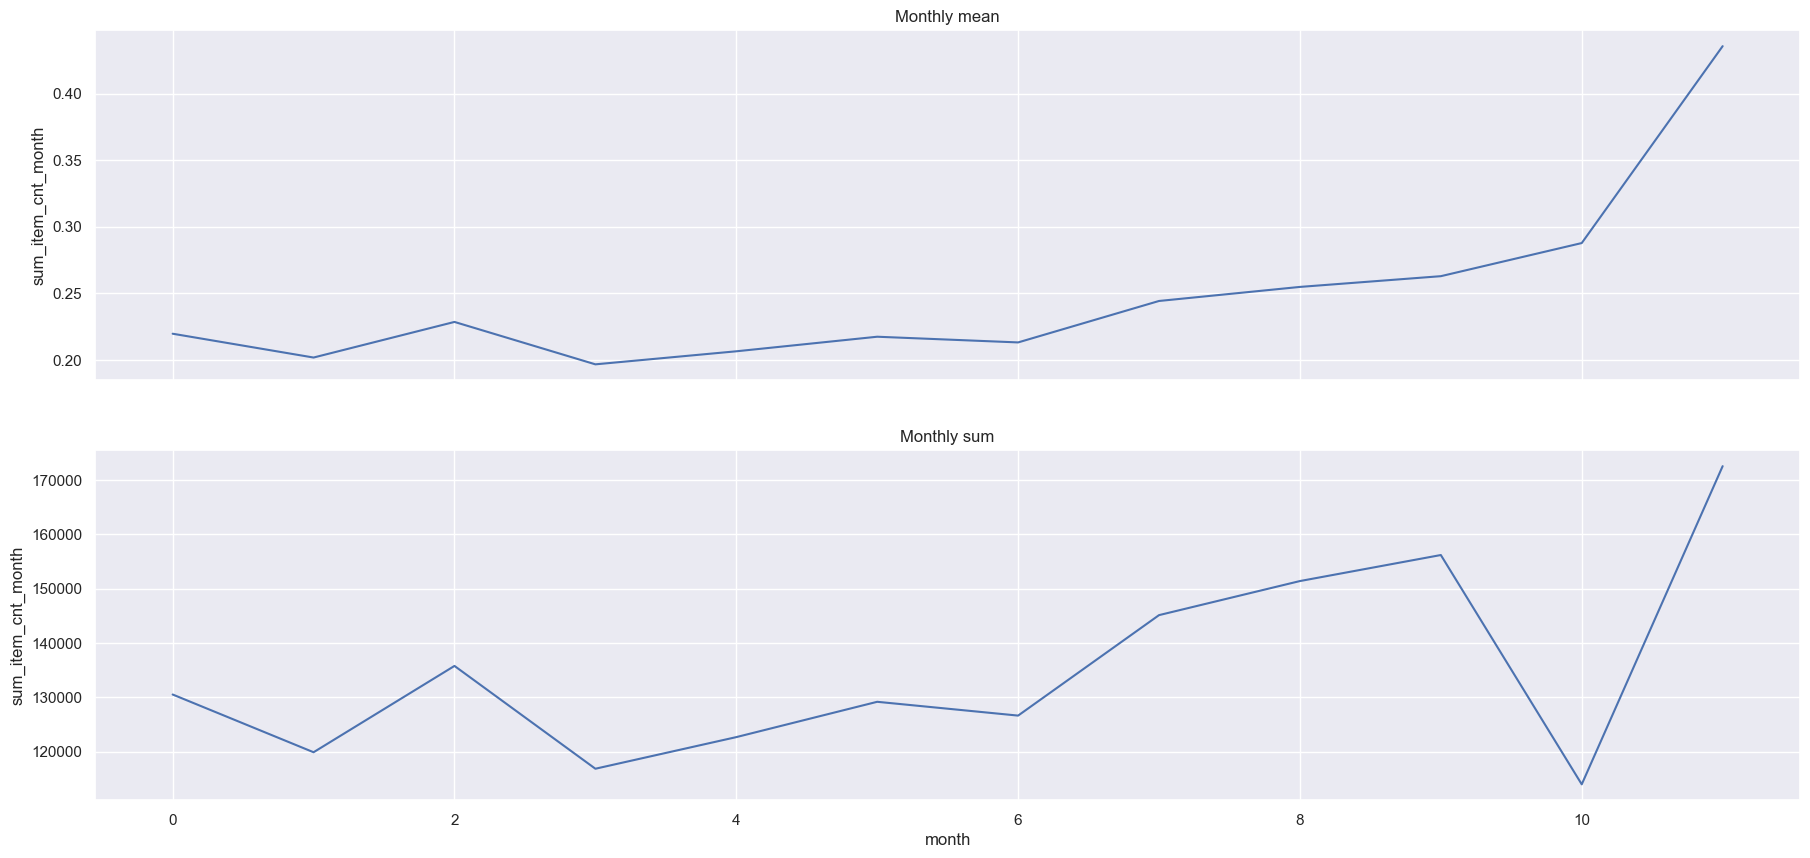

In [42]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="sum_item_cnt_month", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="sum_item_cnt_month", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

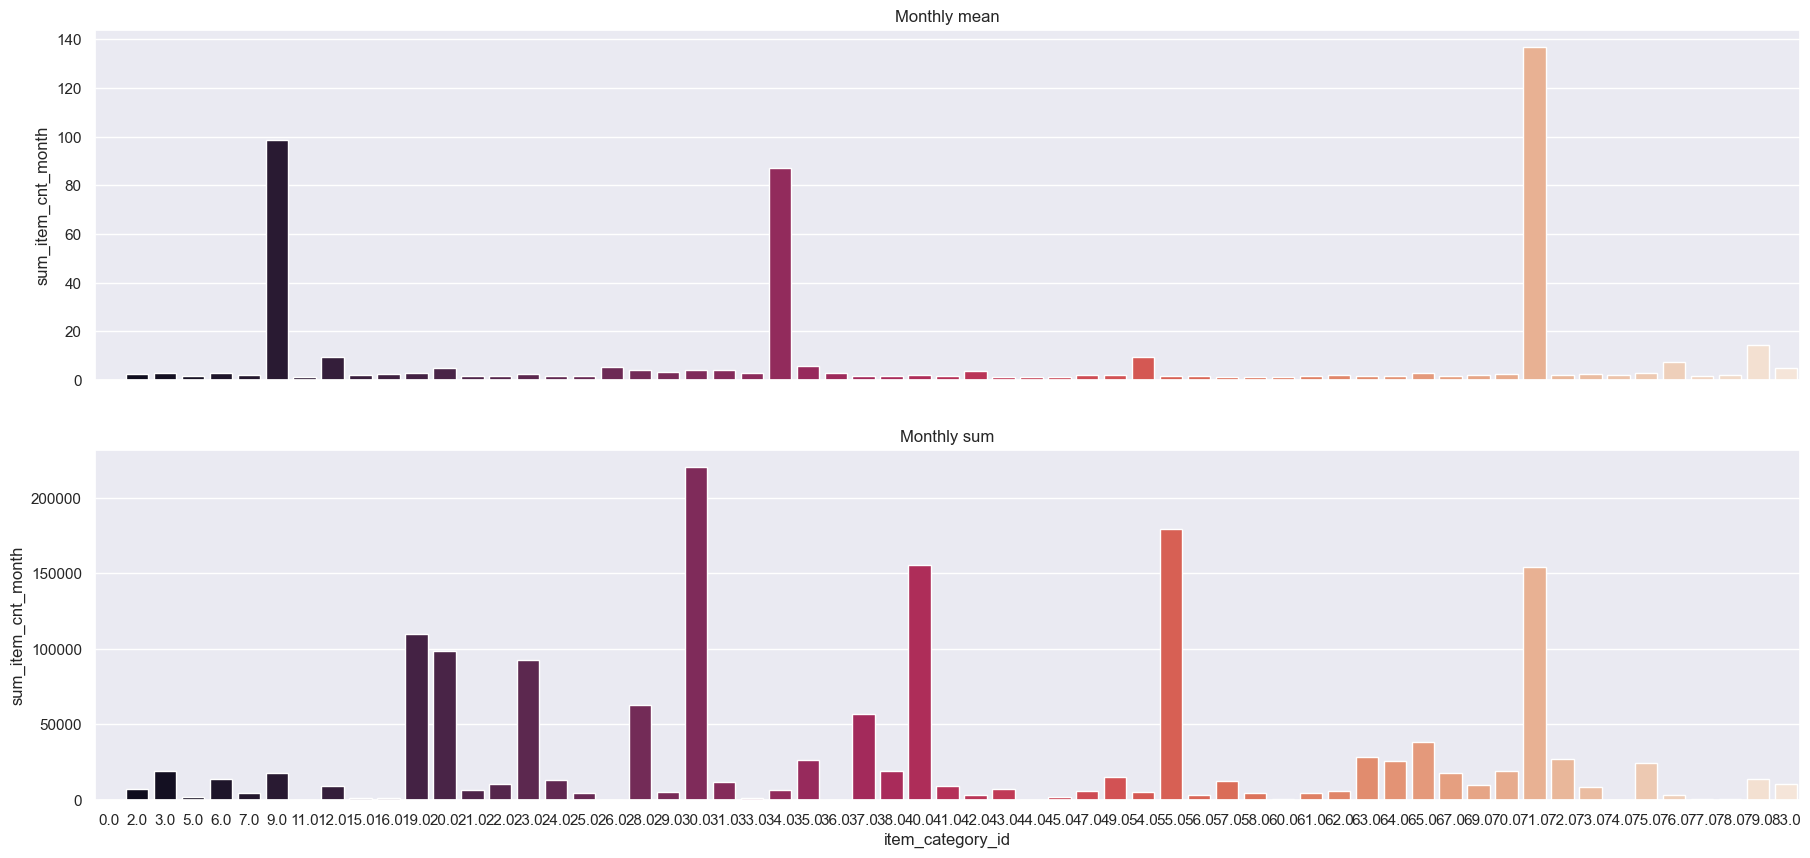

In [43]:
# what categories sell more?
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="sum_item_cnt_month", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="sum_item_cnt_month", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

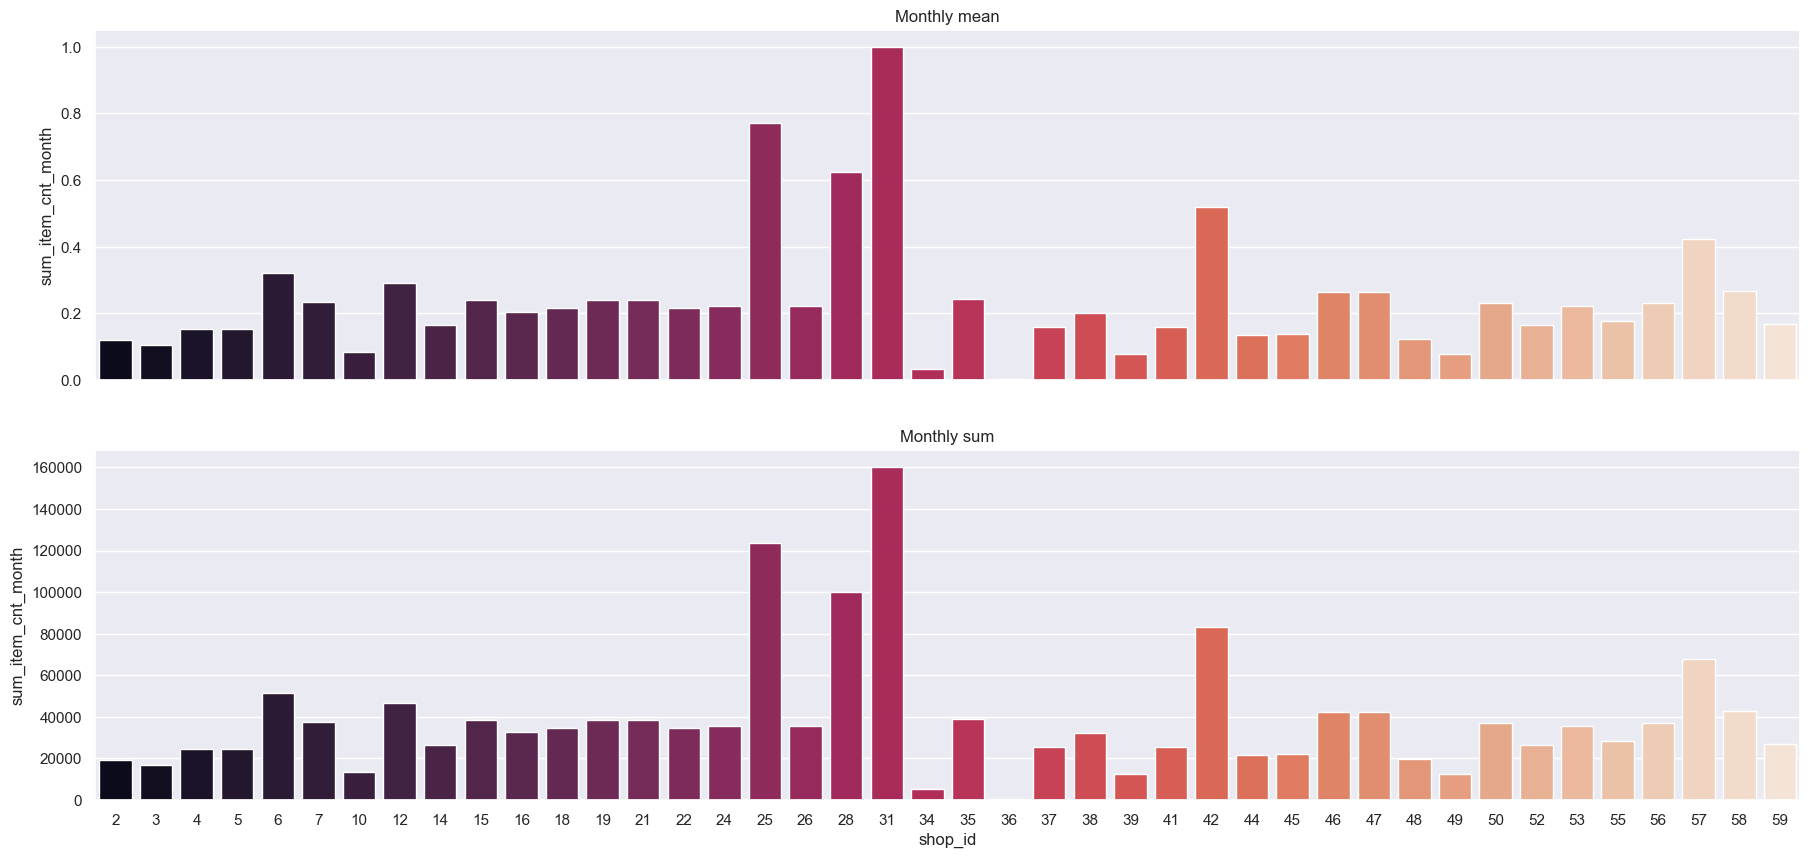

In [44]:
# What shops sell most
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="sum_item_cnt_month", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="sum_item_cnt_month", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

In conclusion, as we can see:
1) we have a trending increase of item sales count (mean) towards the ending of the year.
2) Also only few of the categories seems to hold most of the sell count.
3) Most of the shops have a similar sell rate, but 3 of them have a much higher rate, this may be a indicative of the shop size.


### Checking for outliers

In [ ]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

In [ ]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

In [ ]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()

Removing outliers
I'll treat "item_cnt" > 1500 and < 0, "item_price" > 40,000 as outliers, so I'll remove them.

In [ ]:
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 1500 and item_price < 400000')

# Feature engineering

### Creating the label

Our label will be the "item_cnt" of the next month, as we are dealing with a forecast problem.

In [ ]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)
train_monthly.head()

Unitary item prices.

In [ ]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)
train_monthly.head()

Group based features.

In [ ]:
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

How much each item's price changed from its (lowest/highest) historical price.

train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']